# Recommender System

In [43]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.preprocessing import MinMaxScaler
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./dataset_/cleaned_dataset.csv')
df.head()

,Unnamed: 0,country,uri,popularity,title,artist,release_type,sub_genre,artist_followers,explicit,...,explicit_false,explicit_true,popu_max,top10_dummy,top50_dummy,cluster,duration_min,release_year,release_month,release_day
0,0,Global,https://open.spotify.com/track/6FyRXC8tJUh863J...,31833.95,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,...,1,0,10,1.0,1.0,global,4.31065,2018,11,5
1,1,USA,https://open.spotify.com/track/6FyRXC8tJUh863J...,8.00,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,...,1,0,191,0.0,0.0,english speaking and nordic,4.31065,2018,11,5
2,2,Argentina,https://open.spotify.com/track/6FyRXC8tJUh863J...,76924.40,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,...,1,0,1,1.0,1.0,spanish speaking,4.31065,2018,11,5
3,3,Belgium,https://open.spotify.com/track/6FyRXC8tJUh863J...,849.60,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,...,1,0,126,0.0,0.0,english speaking and nordic,4.31065,2018,11,5
4,4,Switzerland,https://open.spotify.com/track/6FyRXC8tJUh863J...,20739.10,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,...,1,0,21,0.0,1.0,english speaking and nordic,4.31065,2018,11,5


In [3]:
df.shape

(170628, 39)

In [4]:
# drop songs duplication on the basis of same artist name and title of the song
df['artists_song'] = df.apply(lambda row: row['artist']+row['title'],axis = 1)
data = df.drop_duplicates('artists_song')
data.head()

,Unnamed: 0,country,uri,popularity,title,artist,release_type,sub_genre,artist_followers,explicit,...,explicit_true,popu_max,top10_dummy,top50_dummy,cluster,duration_min,release_year,release_month,release_day,artists_song
0,0,Global,https://open.spotify.com/track/6FyRXC8tJUh863J...,31833.95,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,...,0,10,1.0,1.0,global,4.310650,2018,11,5,Paulo Londraadan y eva
16,16,Global,https://open.spotify.com/track/5xhJmd0I15jFcEd...,418.00,it wont kill ya,The Chainsmokers - Louane,album,dance pop,16931568.0,False,...,0,72,0.0,0.0,global,3.626883,2017,4,7,The Chainsmokers - Louaneit wont kill ya
39,39,Global,https://open.spotify.com/track/0wJJhRgdHhT93Z3...,56.00,hymn,Kesha,single,dance pop,5910376.0,True,...,1,131,0.0,0.0,global,3.426667,2017,8,3,Keshahymn
58,58,Global,https://open.spotify.com/track/6JSryEdVJTZq6YB...,78.40,arrows,Foo Fighters,album,alternative metal,8092392.0,False,...,0,103,0.0,0.0,global,4.436450,2017,9,15,Foo Fightersarrows
80,80,Global,https://open.spotify.com/track/7nAfXgeHfDO50up...,244.95,talking to myself,Linkin Park,album,alternative metal,17132813.0,False,...,0,86,0.0,0.0,global,3.855117,2017,5,19,Linkin Parktalking to myself


In [5]:
df2 = df.drop_duplicates(subset=['title'], keep='first')

In [6]:
data = df2[['artist', 'genre', 'country', 'title']]


In [7]:
# names of different artists
print(data['artist'].describe())

# All songs have an artist name
# we have 21718 unique Artist
# 0.0087% (1487/170633) of the songs are of Ariana Grande who is the most occured singer.

count     47044
unique    21718
top         Jul
freq        173
Name: artist, dtype: object


In [8]:
# find the 10 most frequent artist.
Artist_count = Counter(list(data['artist']))
Artist_count.most_common(10)

[('Jul', 173),
 ('BTS', 80),
 ('Future', 78),
 ('Drake', 71),
 ('Kim Larsen', 71),
 ('Djadja & Dinaz', 70),
 ('Taylor Swift', 66),
 ('Mayday', 59),
 ('Ufo361', 55),
 ('Luis Miguel', 55)]

In [9]:
# names of different Genre 
print(data['genre'].describe())

count     47044
unique       20
top         pop
freq      18646
Name: genre, dtype: object


In [10]:
# find the 10 most frequent genre.
Genre_count = Counter(list(data['genre']))
Genre_count.most_common(10)

[('pop', 18646),
 ('hip hop', 12389),
 ('indie', 3552),
 ('latin', 2513),
 ('rap', 2412),
 ('rock', 1477),
 ('dance/electronic', 1382),
 ('r&b/soul', 707),
 ('k-pop', 652),
 ('house', 650)]

In [11]:
# names of different Country 
print(data['country'].describe())

# we have 35 unique Country
# 4.5% (7686/170633) of the songs are from Switzerland.

count      47044
unique        35
top       Global
freq        4456
Name: country, dtype: object


### Bag of words

In [23]:
sample = data.head(2000) # Sample
# sample = data

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(sample['artist'])
title_features.get_shape() # get number of rows and columns in feature matrix.

(2000, 1434)

In [25]:
# Convert matrix to dataframe
artist_df = pd.DataFrame(title_features.toarray())
artist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Utility Functions which we will use through the rest of the code


# #Display an image  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, text, title):
        # keys: list of words of recommended title
    
    # we will devide the whole figure into two parts
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
    fig = plt.figure(figsize=(25,3))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
    ax.set_xticklabels(keys) 
    ax.set_title(title) 
    
    
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, text, title, model):


    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    
    keys = list(vec2.keys())
   
    values = [vec2[x] for x in vec2.keys()]

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_artist_vectorizer.vocabulary_:
                labels.append(tfidf_artist_vectorizer[doc_id, tfidf_artist_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            
            if x in  tfidf_artist_vectorizer.vocabulary_:
                labels.append(tfidf_artist_vectorizer[doc_id, tfidf_artist_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, text, title)


def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) 



def get_result(doc_id, content_a, content_b, title, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)

    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, text2, title, model)

In [27]:
# get_result(indices[i],data['artist'].loc[df_indices[0]], data['artist'].loc[df_indices[i]], data['title'].loc[df_indices[i]], 'bag_of_words')
print(data['artist'].loc[0])


Paulo Londra


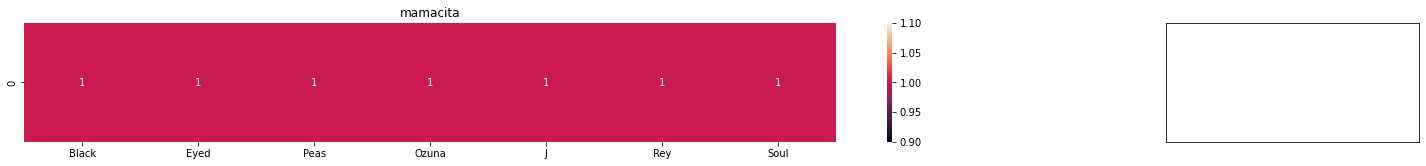

Artist : Black Eyed Peas - Ozuna - J. Rey Soul
Genre: pop
Country: Singapore
Title: mamacita
Euclidean similarity with the query song : 0.0


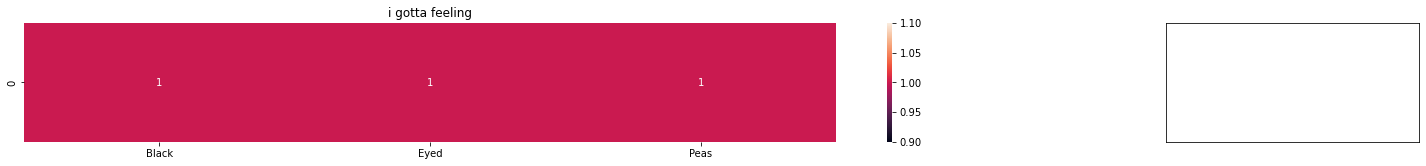

Artist : Black Eyed Peas
Genre: pop
Country: Global
Title: i gotta feeling
Euclidean similarity with the query song : 1.7320508075688772


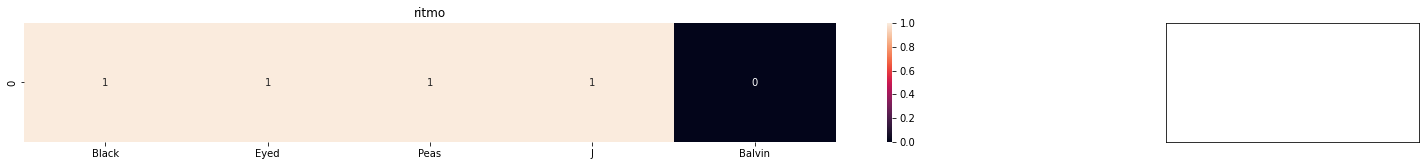

Artist : Black Eyed Peas - J Balvin
Genre: pop
Country: Brazil
Title: ritmo
Euclidean similarity with the query song : 2.0


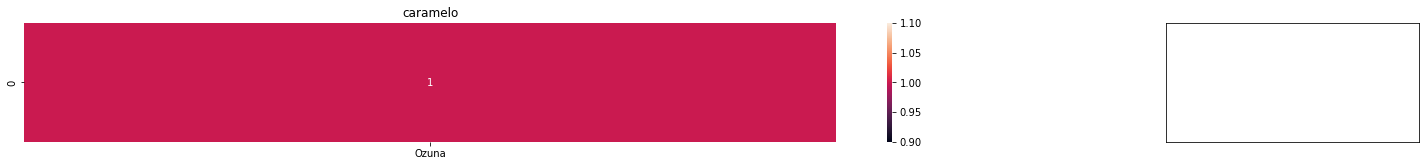

Artist : Ozuna
Genre: latin
Country: Global
Title: caramelo
Euclidean similarity with the query song : 2.23606797749979


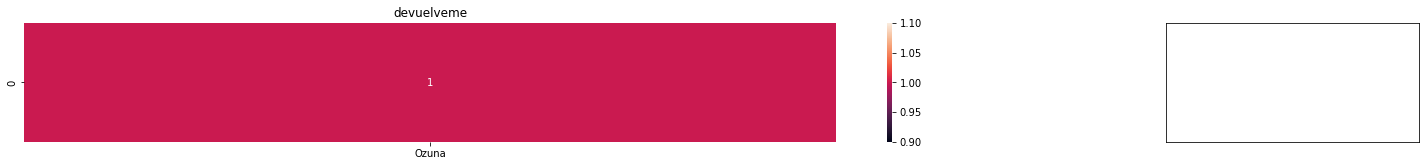

Artist : Ozuna
Genre: latin
Country: Global
Title: devuelveme
Euclidean similarity with the query song : 2.23606797749979


In [28]:

def bag_of_words_model(song_id, num_results):
    
    # pairwise_dist or euclidean distance
    pairwise_dist = pairwise_distances(title_features,title_features[song_id])
    # print(pairwise_dist)
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['artist'].loc[df_indices[0]], data['artist'].loc[df_indices[i]], data['title'].loc[df_indices[i]], 'bag_of_words')
        print('Artist :',data['artist'].loc[df_indices[i]])
        print ('Genre:', data['genre'].loc[df_indices[i]])
        print ('Country:', data['country'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query song :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(58, 5)

### TF-IDF

In [29]:
tfidf_artist_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_artist_features = tfidf_artist_vectorizer.fit_transform(data['artist'])

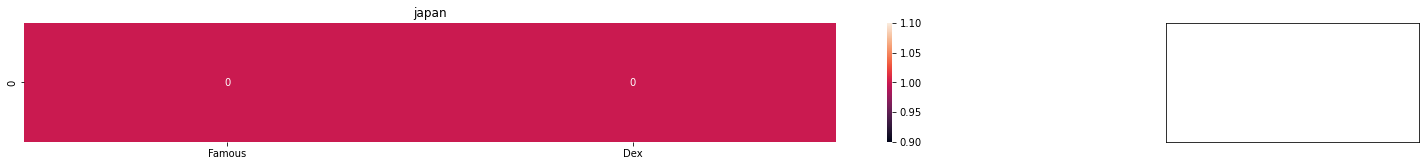

Artist : Famous Dex
Genre: rap
Country: Global
Title: japan
Eucliden distance from the given image : 0.0


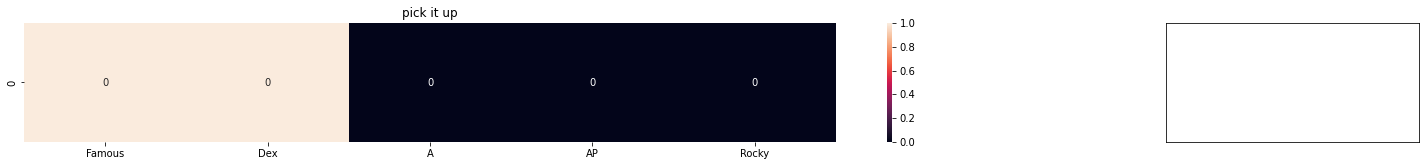

Artist : Famous Dex - A$AP Rocky
Genre: rap
Country: Global
Title: pick it up
Eucliden distance from the given image : 0.6929246795363126


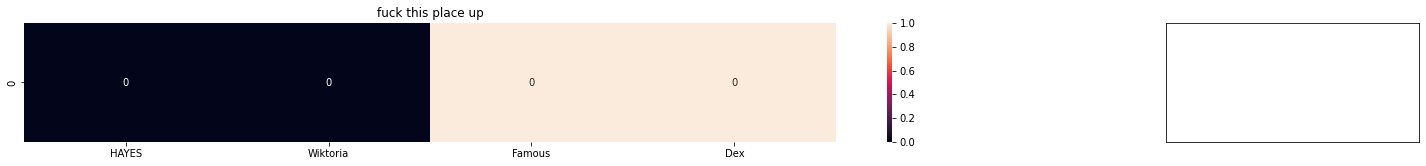

Artist : HAYES - Wiktoria - Famous Dex
Genre: pop
Country: Norway
Title: fuck this place up
Eucliden distance from the given image : 0.8162586087366992


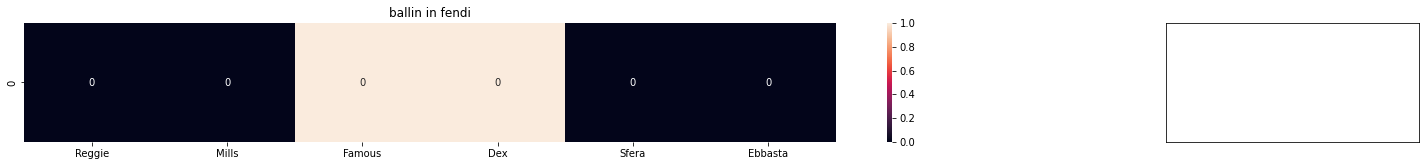

Artist : Reggie Mills - Famous Dex - Sfera Ebbasta
Genre: pop
Country: Italy
Title: ballin in fendi
Eucliden distance from the given image : 0.935071980248401


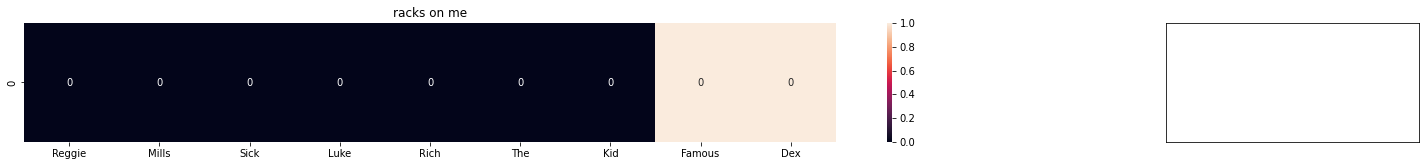

Artist : Reggie Mills - Sick Luke - Rich The Kid - Famous Dex
Genre: pop
Country: Germany
Title: racks on me
Eucliden distance from the given image : 0.9991681168583613


In [30]:
def tfidf_model(song_id, num_results):
    
    # pairwise_dist or euclidean distance
    pairwise_dist = pairwise_distances(tfidf_artist_features,tfidf_artist_features[song_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['artist'].loc[df_indices[0]], data['artist'].loc[df_indices[i]], data['title'].loc[df_indices[i]], 'tfidf')
        print('Artist :',data['artist'].loc[df_indices[i]])
        print ('Genre:', data['genre'].loc[df_indices[i]])
        print ('Country:', data['country'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12, 5)

### Bag of word for all three features

In [31]:
sample = data.head(2000) # Sample

In [32]:
artist_vectorizer = CountVectorizer()
artist_features = artist_vectorizer.fit_transform(sample['artist'])

genre_vectorizer = CountVectorizer()
genre_features = genre_vectorizer.fit_transform(sample['genre'])

country_vectorizer = CountVectorizer()
country_features = genre_vectorizer.fit_transform(sample['country'])

extra_features = hstack((artist_features, genre_features, country_features)).tocsr()

In [33]:
extra_features

<2000x1479 sparse matrix of type '<class 'numpy.int64'>'
	with 10096 stored elements in Compressed Sparse Row format>

In [34]:
# Convert matrix to dataframe
three_feat = pd.DataFrame(extra_features.toarray())
three_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


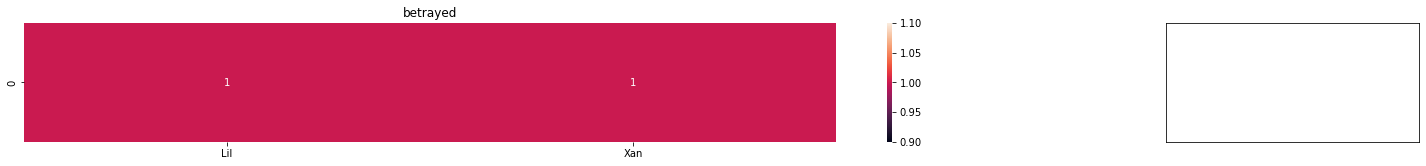

Artist : Lil Xan
Genre: rap
Country: Global
Title: betrayed
Euclidean similarity with the query song : 0.0


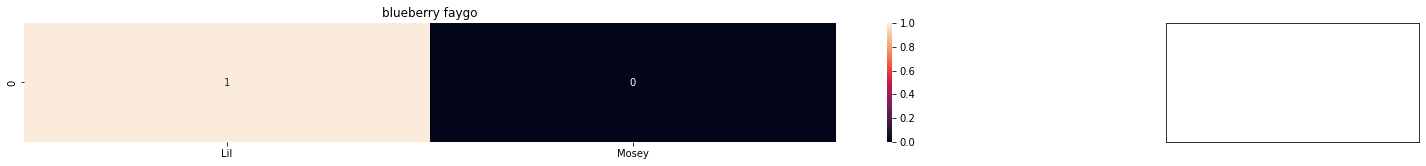

Artist : Lil Mosey
Genre: rap
Country: Global
Title: blueberry faygo
Euclidean similarity with the query song : 1.4142135623730951


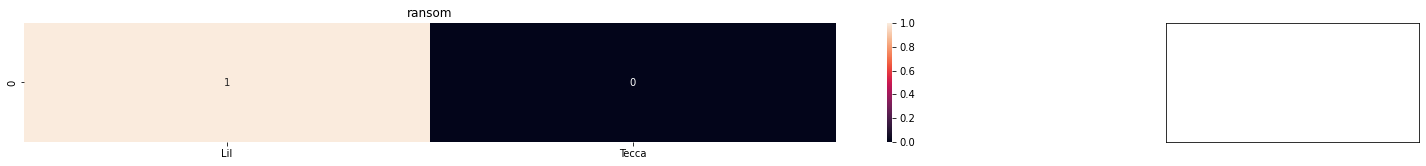

Artist : Lil Tecca
Genre: rap
Country: Global
Title: ransom
Euclidean similarity with the query song : 1.4142135623730951


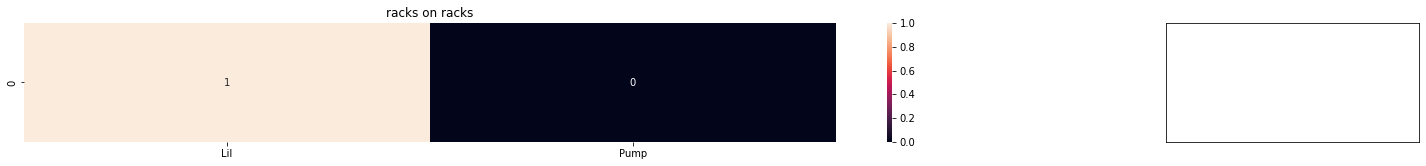

Artist : Lil Pump
Genre: rap
Country: Global
Title: racks on racks
Euclidean similarity with the query song : 1.4142135623730951


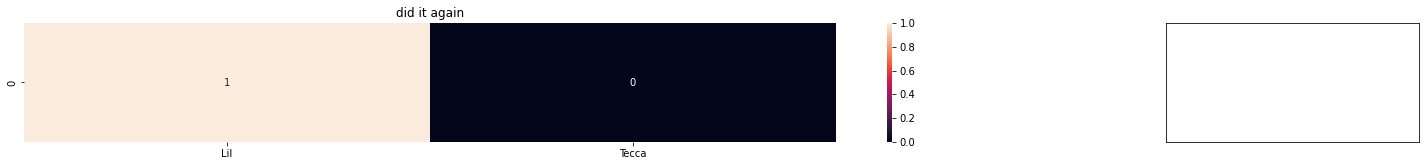

Artist : Lil Tecca
Genre: rap
Country: Global
Title: did it again
Euclidean similarity with the query song : 1.4142135623730951


In [35]:
def bag_of_words_model(song_id, num_results):
    
    # pairwise_dist or euclidean distance
    pairwise_dist = pairwise_distances(extra_features, extra_features[song_id])
    
   
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
   
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['artist'].loc[df_indices[0]], data['artist'].loc[df_indices[i]], data['title'].loc[df_indices[i]], 'bag_of_words')
        print('Artist :',data['artist'].loc[df_indices[i]])
        print ('Genre:', data['genre'].loc[df_indices[i]])
        print ('Country:', data['country'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query song :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(10, 5)

### Again with cosine distance

#### Bag of words

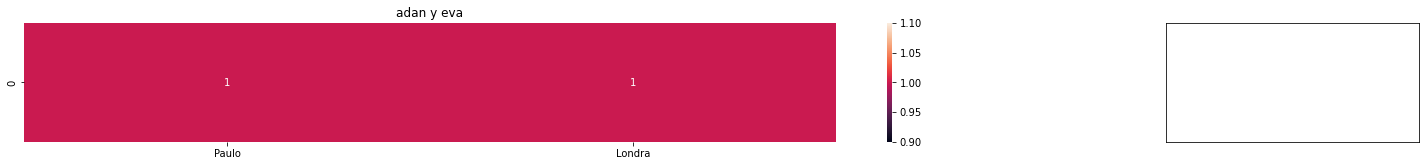

Artist : Paulo Londra
Genre: hip hop
Country: Global
Title: adan y eva
Cosine similarity with the query song : 0.0


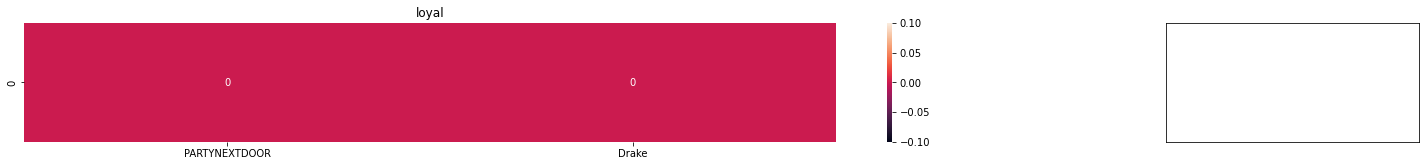

Artist : PARTYNEXTDOOR - Drake
Genre: pop
Country: Global
Title: loyal
Cosine similarity with the query song : 0.0


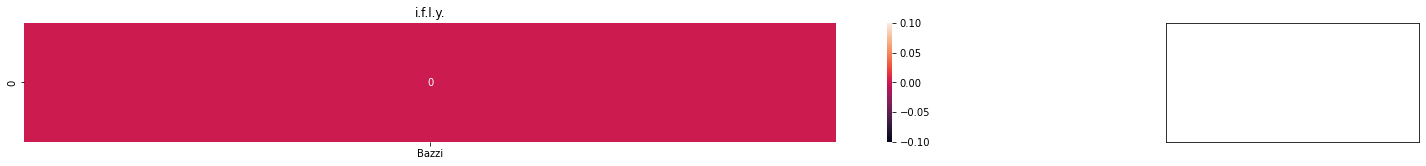

Artist : Bazzi
Genre: pop
Country: Global
Title: i.f.l.y.
Cosine similarity with the query song : 0.0


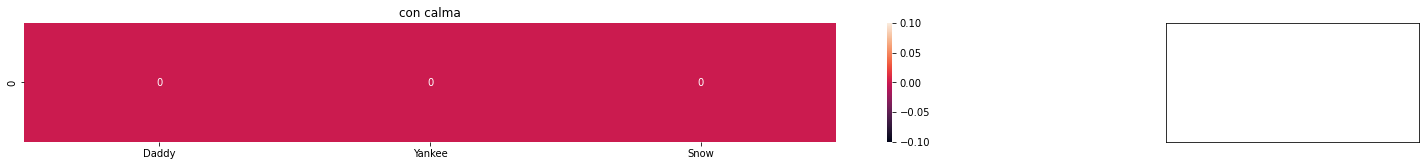

Artist : Daddy Yankee - Snow
Genre: latin
Country: Global
Title: con calma
Cosine similarity with the query song : 0.0


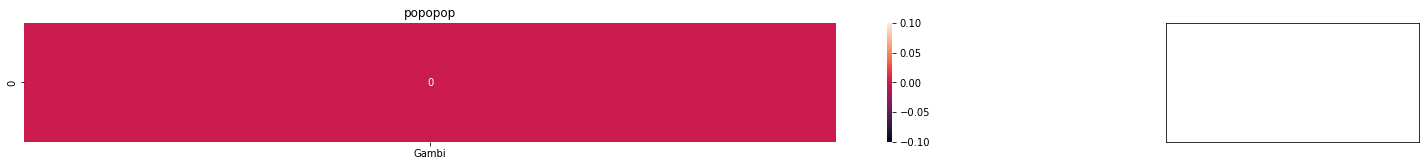

Artist : Gambi
Genre: hip hop
Country: Global
Title: popopop
Cosine similarity with the query song : 0.0


In [36]:
def bag_of_words_model(song_id, num_results):
    
    #cosine distance
    cosine_dist = cosine_similarity(title_features,title_features[song_id])
    
    indices = np.argsort(cosine_dist.flatten())[0:num_results]
    pdists  = np.sort(cosine_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['artist'].loc[df_indices[0]], data['artist'].loc[df_indices[i]], data['title'].loc[df_indices[i]], 'bag_of_words')
        print('Artist :',data['artist'].loc[df_indices[i]])
        print ('Genre:', data['genre'].loc[df_indices[i]])
        print ('Country:', data['country'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Cosine similarity with the query song :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(80, 5)

#### TF-IDF

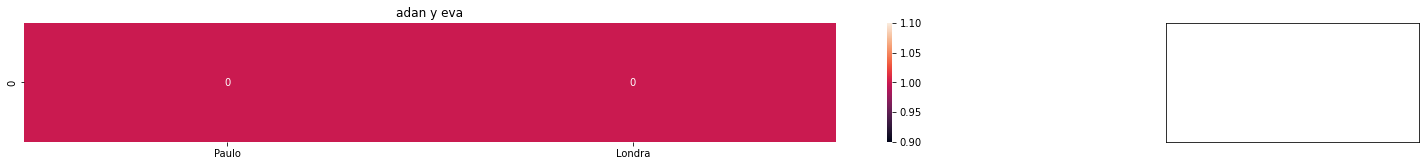

Artist : Paulo Londra
Genre: hip hop
Country: Global
Title: adan y eva
Cosine distance from the given image : 0.0


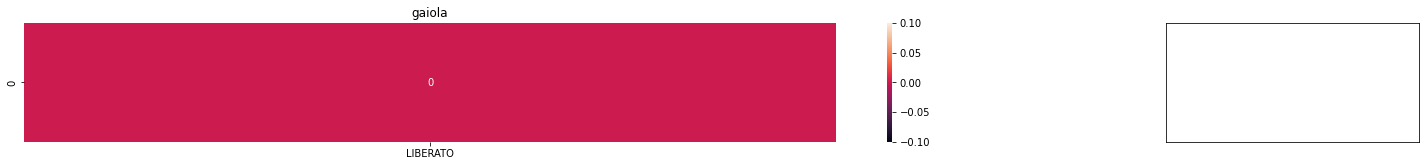

Artist : LIBERATO
Genre: hip hop
Country: Italy
Title: gaiola
Cosine distance from the given image : 0.0


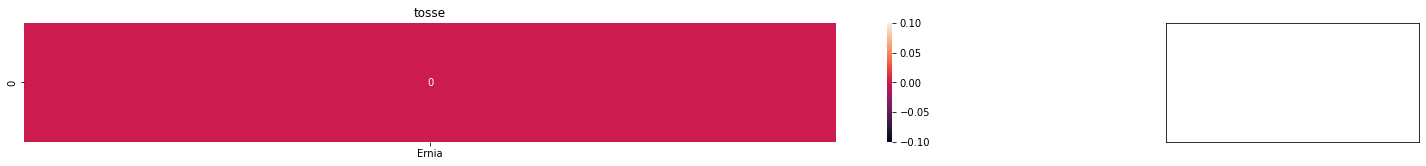

Artist : Ernia
Genre: hip hop
Country: Italy
Title: tosse
Cosine distance from the given image : 0.0


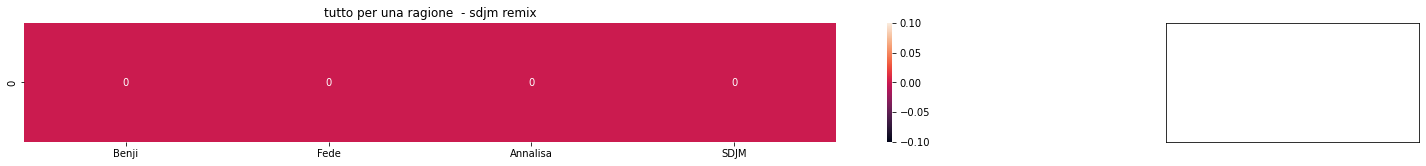

Artist : Benji & Fede - Annalisa - SDJM
Genre: pop
Country: Italy
Title: tutto per una ragione  - sdjm remix
Cosine distance from the given image : 0.0


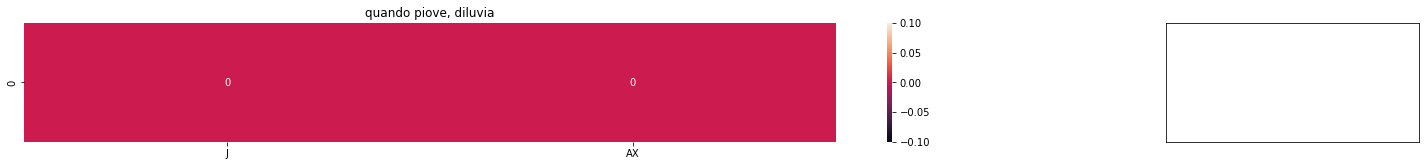

Artist : J-AX
Genre: pop
Country: Italy
Title: quando piove, diluvia
Cosine distance from the given image : 0.0


In [37]:
def tfidf_model(song_id, num_results):
    
    #cosine distance
    cosine_dist = cosine_similarity(tfidf_artist_features,tfidf_artist_features[song_id])

    indices = np.argsort(cosine_dist.flatten())[0:num_results]
    pdists  = np.sort(cosine_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['artist'].loc[df_indices[0]], data['artist'].loc[df_indices[i]], data['title'].loc[df_indices[i]], 'tfidf')
        print('Artist :',data['artist'].loc[df_indices[i]])
        print ('Genre:', data['genre'].loc[df_indices[i]])
        print ('Country:', data['country'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Cosine distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12, 5)

#### using all the three features

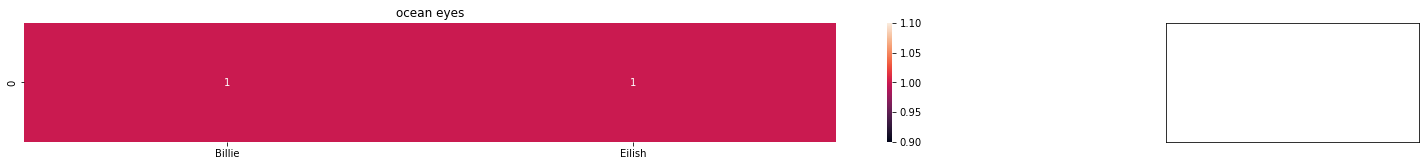

Artist : Billie Eilish
Genre: pop
Country: Malaysia
Title: ocean eyes
Cosine similarity with the query song : 0.0


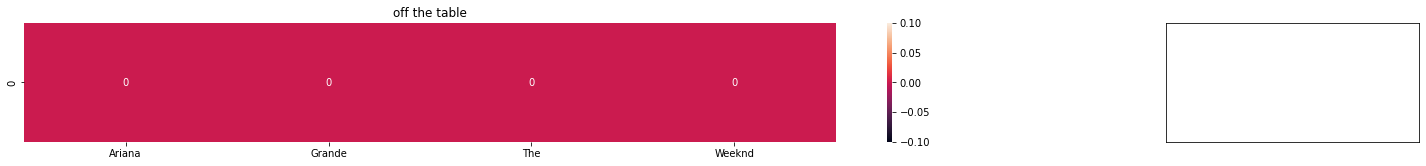

Artist : Ariana Grande - The Weeknd
Genre: pop
Country: Argentina
Title: off the table
Cosine similarity with the query song : 0.0


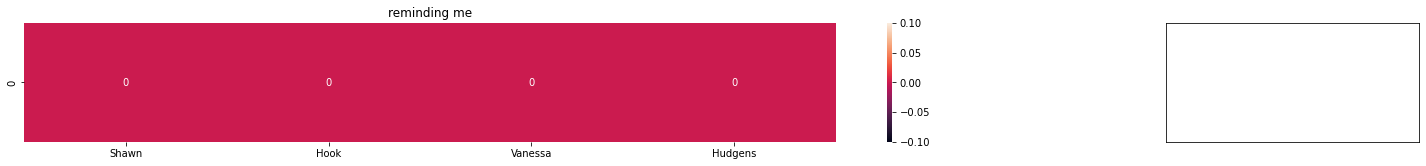

Artist : Shawn Hook - Vanessa Hudgens
Genre: pop
Country: Sweden
Title: reminding me
Cosine similarity with the query song : 0.0


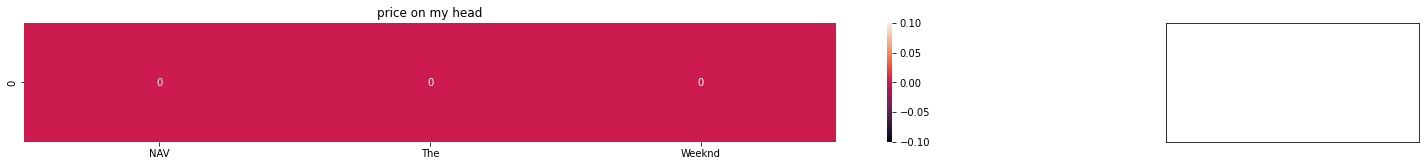

Artist : NAV - The Weeknd
Genre: hip hop
Country: USA
Title: price on my head
Cosine similarity with the query song : 0.0


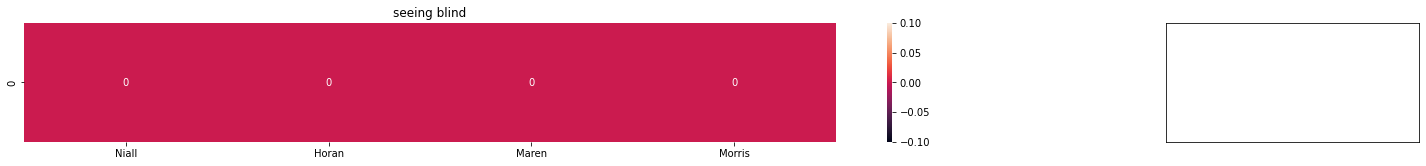

Artist : Niall Horan - Maren Morris
Genre: pop
Country: Australia
Title: seeing blind
Cosine similarity with the query song : 0.0


In [38]:


def bag_of_words_model(song_id, num_results):
    
    #cosine distance 
    cosine_dist = cosine_similarity(extra_features, extra_features[song_id])
    
    indices = np.argsort(cosine_dist.flatten())[0:num_results]
    pdists  = np.sort(cosine_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['artist'].loc[df_indices[0]], data['artist'].loc[df_indices[i]], data['title'].loc[df_indices[i]], 'bag_of_words')
        print('Artist :',data['artist'].loc[df_indices[i]])
        print ('Genre:', data['genre'].loc[df_indices[i]])
        print ('Country:', data['country'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Cosine similarity with the query song :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(10, 5)

### Using manhattan distance

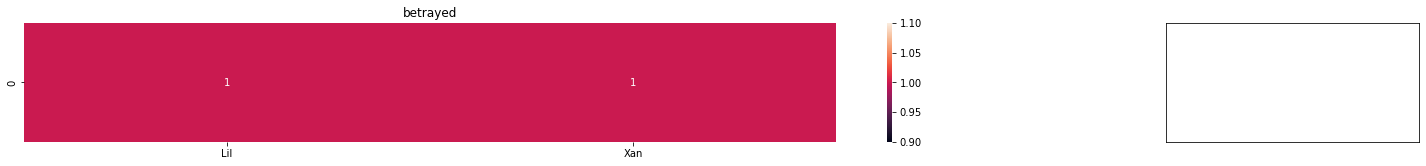

Artist : Lil Xan
Genre: rap
Country: Global
Title: betrayed
Cosine similarity with the query song : 0.0


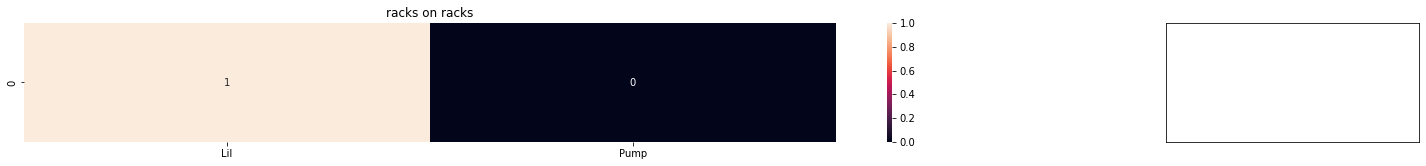

Artist : Lil Pump
Genre: rap
Country: Global
Title: racks on racks
Cosine similarity with the query song : 2.0


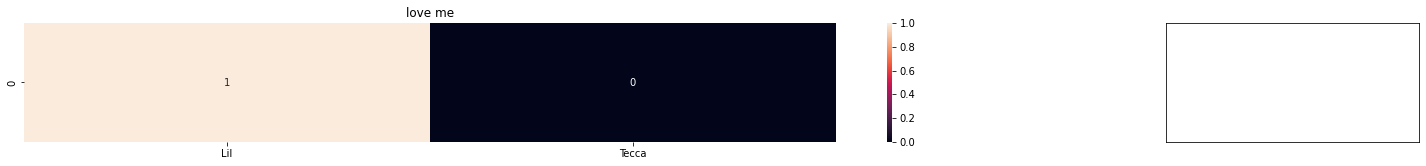

Artist : Lil Tecca
Genre: rap
Country: Global
Title: love me
Cosine similarity with the query song : 2.0


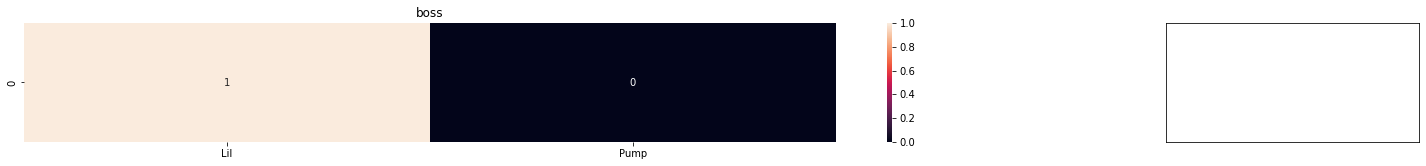

Artist : Lil Pump
Genre: rap
Country: Global
Title: boss
Cosine similarity with the query song : 2.0


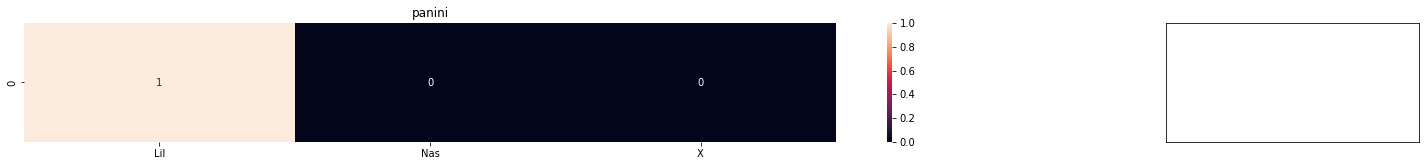

Artist : Lil Nas X
Genre: rap
Country: Global
Title: panini
Cosine similarity with the query song : 2.0


In [39]:


def bag_of_words_model(song_id, num_results):
    
    # manhattan distance
    manhat_dist = manhattan_distances(extra_features, extra_features[song_id])
    
    indices = np.argsort(manhat_dist.flatten())[0:num_results]
    pdists  = np.sort(manhat_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['artist'].loc[df_indices[0]], data['artist'].loc[df_indices[i]], data['title'].loc[df_indices[i]], 'bag_of_words')
        print('Artist :',data['artist'].loc[df_indices[i]])
        print ('Genre:', data['genre'].loc[df_indices[i]])
        print ('Country:', data['country'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Cosine similarity with the query song :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(10, 5)

# With other features
## Remove duplicate to get better results

In [40]:
df = df.drop_duplicates(subset=['title'], keep='first')

In [41]:
data = df[['artist', 'genre', 'country', 'title', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]

In [44]:
scaler = MinMaxScaler()
data['loudness'] = scaler.fit_transform(data['loudness'].values.reshape(-1, 1))

In [45]:
data['loudness'].describe()

count    47044.000000
mean         0.861592
std          0.045312
min          0.000000
25%          0.841581
50%          0.868815
75%          0.890542
max          1.000000
Name: loudness, dtype: float64

In [46]:
scaler = MinMaxScaler()
data['danceability'] = scaler.fit_transform(data['danceability'].values.reshape(-1, 1))

In [47]:
scaler = MinMaxScaler()
data['energy'] = scaler.fit_transform(data['energy'].values.reshape(-1, 1))

In [48]:
scaler = MinMaxScaler()
data['mode'] = scaler.fit_transform(data['mode'].values.reshape(-1, 1))

In [49]:
scaler = MinMaxScaler()
data['speechiness'] = scaler.fit_transform(data['speechiness'].values.reshape(-1, 1))

In [50]:
scaler = MinMaxScaler()
data['acoustics'] = scaler.fit_transform(data['acoustics'].values.reshape(-1, 1))

In [51]:
# data = data.head(200)      # 200 Sample taken because data is note cleaned
# all_data = all_data.head(200)

In [52]:
# Check the DTYPE
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47044 entries, 0 to 170627
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   artist        47044 non-null  object 
 1   genre         47044 non-null  object 
 2   country       47044 non-null  object 
 3   title         47044 non-null  object 
 4   danceability  47044 non-null  float64
 5   energy        47044 non-null  float64
 6   loudness      47044 non-null  float64
 7   mode          47044 non-null  float64
 8   speechiness   47044 non-null  float64
 9   acoustics     47044 non-null  float64
dtypes: float64(6), object(4)
memory usage: 3.9+ MB


In [53]:
# Convert all the datatype to numeric
# numeric_df = data.apply(pd.to_numeric)
# numeric_df.info()

In [54]:
# Select Features
sample_data = df[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]

In [55]:
# Cosine distance between 0th datapoint wrt all rows of the dataframe
cosine_dist = cosine_similarity(sample_data, sample_data.iloc[0].values.reshape(1, -1))
print(cosine_dist)

[[1.        ]
 [0.96403453]
 [0.99392408]
 ...
 [0.96919727]
 [0.97693228]
 [0.99711189]]


In [56]:
indices = np.argsort(cosine_dist.flatten())     # indices after sorting the cosine scores
print(indices)
pdists  = np.sort(cosine_dist.flatten())[0:10]    # distance of the sorted indices
print(pdists)
print(pdists[::-1])

[ 6919  2982 22617 ...  2395 11672     0]
[-0.62512658 -0.53471761 -0.13206219 -0.07942404 -0.0306228  -0.01368303
  0.10919647  0.13321148  0.16893864  0.19675968]
[ 0.19675968  0.16893864  0.13321148  0.10919647 -0.01368303 -0.0306228
 -0.07942404 -0.13206219 -0.53471761 -0.62512658]


In [57]:
cosine_dist[cosine_dist < 0]

array([-0.53471761, -0.62512658, -0.0306228 , -0.01368303, -0.07942404,
       -0.13206219])

In [58]:
cosine_dist[2982]

array([-0.53471761])

In [ ]:
cosine_list = list(cosine_dist.flatten())
cosine_list

In [60]:
neg_nos = [num for num in cosine_list if num < 0]
neg_nos

[-0.5347176104931053,
 -0.6251265766310811,
 -0.030622798709229418,
 -0.013683031368302843,
 -0.07942403557026848,
 -0.1320621908934179]

In [63]:
# print(cosine_list.index(-0.5347176104931053))
# print(cosine_list.index(-0.6251265766310811))
# print(cosine_list.index(-0.030622798709229432))
# print(cosine_list.index(-0.013683031368302841))
# print(cosine_list.index(-0.07942403557026846))
# print(cosine_list.index(-0.13206219089341792))

In [64]:
print(sample_data.iloc[2982].values.reshape(1, -1))
print(sample_data.iloc[0].values.reshape(1, -1))
cosine_dist = cosine_similarity(sample_data.iloc[2982].values.reshape(1, -1), sample_data.iloc[0].values.reshape(1, -1))
print(cosine_dist) 

[[0.962  0.787  1.509  0.     0.0554 0.666 ]]
[[ 0.767  0.709 -4.47   1.     0.336  0.323]]
[[-0.53471761]]


In [65]:
len(cosine_dist[0])

1

adan y eva


[]

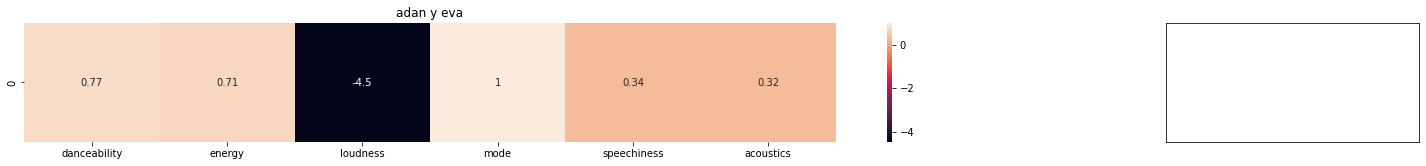

In [66]:
# heatmap
text = data['title'].iloc[0]
values = sample_data.iloc[0].values
keys = sample_data.columns
print(text)
gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
fig = plt.figure(figsize=(25,3))
ax = plt.subplot(gs[0])
ax = sns.heatmap(np.array([values]), annot=True)
ax.set_xticklabels(keys) 
ax.set_title(text) 
ax = plt.subplot(gs[1])
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

In [67]:
indices = np.argsort(cosine_dist.flatten())     # indices after sorting the cosine scores
print(indices)
pdists  = np.sort(cosine_dist.flatten())[0:10]    # distance of the sorted indices
pdists

[0]


array([-0.53471761])

In [68]:
df_indices = list(data.index[indices])
print(df_indices)

[0]


In [69]:
def plot_heatmap_numeric(keys, values, title):
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
    fig = plt.figure(figsize=(25,3))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]), annot=True)
    ax.set_xticklabels(keys) 
    ax.set_title(title)   
    
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# plot_heatmap(keys, values, title)


In [81]:
def other_model(song_id, num_results, all_data):
    
    #cosine distance  
    data = all_data[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]
    cosine_dist = cosine_similarity(data.iloc[song_id].values.reshape(1, -1), data)

    indices = np.argsort(cosine_dist.flatten())[::-1][0:num_results]
    pdists  = np.sort(cosine_dist.flatten())[::-1][0:num_results]

    df_indices = list(data.index[indices])
    print("Query song")
    print()
    # plot_heatmap_numeric(data.columns, data.iloc[song_id], all_data['title'].iloc[song_id])


    for i in range(0,len(indices)):
        # ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']
        # get_result(indices[i],all_data['artist'].loc[df_indices[0]], all_data['artist'].loc[df_indices[i]], all_data['title'].loc[df_indices[i]], 'other features, ')
        # print()
        # print()
        print("Recommendation", i)
        # plot_heatmap_numeric(data.columns, data.loc[df_indices[i]], all_data['title'].loc[df_indices[i]])
        # print()
        print('Artist :',all_data['artist'].loc[df_indices[i]])
        print ('Genre:', all_data['genre'].loc[df_indices[i]])
        print ('Country:', all_data['country'].loc[df_indices[i]])
        print ('Title:', all_data['title'].loc[df_indices[i]])
        print ('Cosine distance from the given query :', pdists[i])
        print('='*125)
other_model(1, 8, data)

Query song

Recommendation 0
Artist : The Chainsmokers - Louane
Genre: pop
Country: Global
Title: it wont kill ya
Cosine distance from the given query : 1.0000000000000002
Recommendation 1
Artist : SVEA
Genre: pop
Country: Sweden
Title: all my exes
Cosine distance from the given query : 0.9998182147103069
Recommendation 2
Artist : Petter - Joel Alme
Genre: hip hop
Country: Sweden
Title: barnängens ängar
Cosine distance from the given query : 0.9996880611105337
Recommendation 3
Artist : Lady Gaga
Genre: pop
Country: Ireland
Title: heal me
Cosine distance from the given query : 0.9995968565213865
Recommendation 4
Artist : Page Four
Genre: pop
Country: Denmark
Title: koldt udenfor
Cosine distance from the given query : 0.9995305939689436
Recommendation 5
Artist : Juice WRLD
Genre: rap
Country: Global
Title: screw juice
Cosine distance from the given query : 0.9995286464610459
Recommendation 6
Artist : Joey Moe
Genre: hip hop
Country: Denmark
Title: hey mor
Cosine distance from the given q

In [71]:
data.iloc[11]  

artist          Douglas & Vinicius - MC Bruninho
genre                                        pop
country                                   Global
title                        figurinha - ao vivo
danceability                            0.601221
energy                                     0.757
loudness                                0.920322
mode                                         1.0
speechiness                             0.075983
acoustics                                0.34739
Name: 191, dtype: object

In [72]:
data[data['title'] == 'we are your friends - justice vs. simian']

,artist,genre,country,title,danceability,energy,loudness,mode,speechiness,acoustics
90829,Justice - Simian,dance/electronic,UK,we are your friends - justice vs. simian,0.657172,0.977,1.0,0.0,0.172878,0.010241


In [73]:
data['loudness'].describe()

count    47044.000000
mean         0.861592
std          0.045312
min          0.000000
25%          0.841581
50%          0.868815
75%          0.890542
max          1.000000
Name: loudness, dtype: float64

#### usually a value higher than 0.5 shows strong similarities.

#### A cosine value of 0 means that the two vectors are at 90 degrees to each other (orthogonal) and have no match. The closer the cosine value to 1, the smaller the angle and the greater the match between vectors.

# Combining features

In [74]:
artist_df

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
all_features = data[['artist', 'genre', 'country', 'title', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]
num_features = data[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]
numerical_features = num_features.head(2000)
numerical_features.reset_index(drop = True, inplace=True)
frames = [numerical_features, artist_df]
combined_df = pd.concat(frames, axis=1)
combined_df

,danceability,energy,loudness,mode,speechiness,acoustics,0,1,2,3,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433
0,0.780264,0.709,0.901681,1.0,0.347826,0.324297,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.581892,0.530,0.835902,0.0,0.067702,0.064960,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.496439,0.538,0.893497,1.0,0.078675,0.147590,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.523906,0.917,0.855533,1.0,0.043168,0.000210,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.603255,0.712,0.871560,0.0,0.029607,0.001847,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.679552,0.826,0.901746,1.0,0.039648,0.023695,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0.687691,0.869,0.948721,1.0,0.043789,0.115462,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0.761953,0.774,0.873248,1.0,0.124224,0.086044,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0.397762,0.595,0.859073,0.0,0.042547,0.916667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
def other_model(song_id, num_results, all_data):
    
    #cosine distance  
    # data = all_data[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]
    cosine_dist = cosine_similarity(all_data.iloc[song_id].values.reshape(1, -1), all_data)

    indices = np.argsort(cosine_dist.flatten())[::-1][0:num_results]
    pdists  = np.sort(cosine_dist.flatten())[::-1][0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']
        # get_result(indices[i],all_data['artist'].loc[df_indices[0]], all_data['artist'].loc[df_indices[i]], all_data['title'].loc[df_indices[i]], 'other features, ')
        print('Artist :',all_features['artist'].loc[df_indices[i]])
        print ('Genre:', all_features['genre'].loc[df_indices[i]])
        print ('Country:', all_features['country'].loc[df_indices[i]])
        print ('Title:', all_features['title'].loc[df_indices[i]])
        print ('Cosine distance from the given query :', pdists[i])
        print('='*125)
other_model(1, 8, combined_df)

Artist : The Chainsmokers - Louane
Genre: pop
Country: Global
Title: it wont kill ya
Cosine distance from the given query : 1.0
Artist : The Chainsmokers
Genre: pop
Country: Global
Title: honest
Cosine distance from the given query : 0.8748835733917032
Artist : The Chainsmokers
Genre: pop
Country: Global
Title: kills you slowly
Cosine distance from the given query : 0.8734488335759865
Artist : The Chainsmokers
Genre: pop
Country: Global
Title: you owe me
Cosine distance from the given query : 0.8703186007234981
Artist : The Chainsmokers
Genre: pop
Country: Global
Title: paris
Cosine distance from the given query : 0.7741496870970489
Artist : The Chainsmokers - Coldplay
Genre: pop
Country: Global
Title: something just like this
Cosine distance from the given query : 0.7731529733611496
Artist : Coldplay - The Chainsmokers
Genre: indie
Country: Global
Title: something just like this - tokyo remix
Cosine distance from the given query : 0.7592769374738421
Artist : The Chainsmokers - Kygo
Ge

## Combining three features with numerical features

In [77]:
all_features = data[['artist', 'genre', 'country', 'title', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]
num_features = data[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]
numerical_features = num_features.head(2000)
numerical_features.reset_index(drop = True, inplace=True)
frames = [numerical_features, three_feat]
combined_df = pd.concat(frames, axis=1)
combined_df

,danceability,energy,loudness,mode,speechiness,acoustics,0,1,2,3,...,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478
0,0.780264,0.709,0.901681,1.0,0.347826,0.324297,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.581892,0.530,0.835902,0.0,0.067702,0.064960,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.496439,0.538,0.893497,1.0,0.078675,0.147590,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.523906,0.917,0.855533,1.0,0.043168,0.000210,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.603255,0.712,0.871560,0.0,0.029607,0.001847,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.679552,0.826,0.901746,1.0,0.039648,0.023695,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0.687691,0.869,0.948721,1.0,0.043789,0.115462,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0.761953,0.774,0.873248,1.0,0.124224,0.086044,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0.397762,0.595,0.859073,0.0,0.042547,0.916667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
def other_model(song_id, num_results, all_data):
    
    #cosine distance  
    # data = all_data[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']]
    cosine_dist = cosine_similarity(all_data.iloc[song_id].values.reshape(1, -1), all_data)

    indices = np.argsort(cosine_dist.flatten())[::-1][0:num_results]
    pdists  = np.sort(cosine_dist.flatten())[::-1][0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acoustics']
        # get_result(indices[i],all_data['artist'].loc[df_indices[0]], all_data['artist'].loc[df_indices[i]], all_data['title'].loc[df_indices[i]], 'other features, ')
        print('Artist :',all_features['artist'].loc[df_indices[i]])
        print ('Genre:', all_features['genre'].loc[df_indices[i]])
        print ('Country:', all_features['country'].loc[df_indices[i]])
        print ('Title:', all_features['title'].loc[df_indices[i]])
        print ('Cosine distance from the given query :', pdists[i])
        print('='*125)
other_model(19, 8, combined_df)

Artist : Gorillaz - De La Soul
Genre: hip hop
Country: Global
Title: momentz
Cosine distance from the given query : 1.0
Artist : Gorillaz
Genre: hip hop
Country: Global
Title: kansas
Cosine distance from the given query : 0.838139220211969
Artist : Gorillaz - Jehnny Beth
Genre: hip hop
Country: Global
Title: we got the power
Cosine distance from the given query : 0.7408090432239375
Artist : Gorillaz - Kali Uchis
Genre: hip hop
Country: Global
Title: shes my collar
Cosine distance from the given query : 0.7400197260349223
Artist : Logic
Genre: hip hop
Country: Global
Title: everybody dies
Cosine distance from the given query : 0.7292166874323488
Artist : Logic
Genre: hip hop
Country: Global
Title: keanu reeves
Cosine distance from the given query : 0.7284871730351354
Artist : Salmo
Genre: hip hop
Country: Global
Title: ho paura di uscire
Cosine distance from the given query : 0.7270629688873288
Artist : Eminem
Genre: hip hop
Country: Global
Title: stepdad
Cosine distance from the given 